In [5]:
library(arrow)
library(czso)
library(RCzechia)
library(tidyverse)

theme_set(
  theme_minimal() +
    theme(
      plot.title = element_text(face = "bold")
    )
)

theme_map <- function() {
  theme(
    axis.text = element_blank(),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank()
  )
}

colours <- list(
  teal = "#1c81a2"
)


## Načítání a příprava dat


In [6]:
nzu <- read_parquet("../../data/mzp-cr/nzu-czso.parquet")

municipalities_czso <- czso_get_table("struktura_uzemi_cr") |>
  select(obec_text, obec_kod, orp_text, orp_csu_cis65_kod, kraj_text)

municipalities_population <- czso_get_table("sldb2021_bydl1rok_pohlavi") |>
  filter(
    # Keep municipalities only.
    uzemi_cis == 43,
    # Basic administrative divisions.
    bydl_cleneni_typ == 1
  ) |>
  summarise(hodnota = sum(hodnota), .by = uzemi_kod) |>
  inner_join(
    municipalities_czso,
    join_by(uzemi_kod == obec_kod)
  ) |>
  select(
    City = obec_text,
    CityCode = uzemi_kod,
    ORP = orp_text,
    ORPCode = orp_csu_cis65_kod,
    Region = kraj_text,
    Population = hodnota
  )

municipalities_houses <- czso_get_table("sldb2021_domy_obydlen_druh") |>
  filter(
    sldb_rok == 2021,
    # Number of houses.
    ukaz_kod == 2409,
    # Family houses, "Rodinné domy".
    druh_kod == 51,
    # Municipalities only.
    uzemi_cis == 43
  ) |>
  summarise(
    hodnota = sum(hodnota),
    .by = uzemi_kod
  ) |>
  inner_join(
    select(municipalities_czso, obec_kod, orp_csu_cis65_kod, kraj_text),
    join_by(uzemi_kod == obec_kod)
  ) |>
  select(
    CityCode = uzemi_kod,
    ORPCode = orp_csu_cis65_kod,
    Region = kraj_text,
    NumHouses = hodnota
  )

regions_gdp <- czso_get_table("050101") |>
  filter(
    # Gross domestic product in nominal millions CZK.
    vuk == "NUC0002",
    # Region level.
    uzemi_cis == 100,
    rok == 2023
  ) |>
  select(hodnota, uzemi_kod, uzemi_txt) |>
  select(
    Region = uzemi_txt,
    GDP = hodnota
  )


ℹ File already in /tmp/RtmpYRP97m/struktura_uzemi_cr, not downloading.
Set `force_redownload = TRUE` if needed.
ℹ File already in /tmp/RtmpYRP97m/sldb2021_bydl1rok_pohlavi, not downloading.
Set `force_redownload = TRUE` if needed.
ℹ File already in /tmp/RtmpYRP97m/sldb2021_domy_obydlen_druh, not downloading.
Set `force_redownload = TRUE` if needed.
ℹ File already in /tmp/RtmpYRP97m/050101, not downloading.
Set `force_redownload = TRUE` if needed.


In [7]:
aggregate_data <- function(.data, admin_level = "obec", by = NULL, subset = NULL, normalize = NULL) {
  stopifnot(
    "Argument 'admin_level' must be one of 'obec', 'orp' or 'kraj' or NULL" =
      admin_level %in% c("obec", "orp", "kraj"),
    "Argument 'by' must be 'call', 'categories', 'both' or NULL" =
      is.null(by) | by %in% c("both", "call", "categories"),
    "Argument 'normalize' must be 'gdp', 'houses', 'pop' or NULL" =
      is.null(normalize) | normalize %in% c("gdp", "houses", "pop"),
    "Normalization by GDP can only be done at the country or region level" =
      # Equivalently, (normalize == "gdp") implies (is.null(admin_level) | admin_level == "kraj")
      is.null(normalize) | normalize != "gdp" | is.null(admin_level) | admin_level == "kraj"
  )

  aggregated <- ungroup(.data)

  # 1. Filter applications according to specified criteria.
  criteria <- enquo(subset)
  if (!rlang::quo_is_null(criteria)) {
    aggregated <- filter(.data, !!criteria)
  }

  # 2. Aggregate across calls and/or categories (or preserve levels).
  if (!is.null(by)) {
    if (by == "call" | by == "both") {
      aggregated <- group_by(aggregated, CallID, .add = TRUE)
    }

    if (by == "categories" | by == "both") {
      aggregated <- aggregated |>
        # TODO: This disaggregates combinations. Do we want to have
        # an option to keep the combinations intact?
        # separate_longer_delim(CategoriesDetail, delim = "|") |>
        # rename(CategoryDetail = CategoriesDetail) |>
        group_by(CategoriesDetail, .add = TRUE)
    }
  }

  # 3. Aggregate at the desider administrative level.
  if (is.null(admin_level)) {
    # Aggregate at the contry level = do nothing at this point.
  } else if (admin_level == "obec") {
    aggregated <- group_by(aggregated, City, CityCode, ORP, ORPCode, Region, .add = TRUE)
  } else if (admin_level == "orp") {
    aggregated <- group_by(aggregated, ORP, ORPCode, Region, .add = TRUE)
  } else {
    stopifnot(admin_level == "kraj")
    aggregated <- group_by(aggregated, Region, .add = TRUE)
  }

  aggregated <- aggregated |>
    summarise(
      AmountPaid = sum(AmountPaid),
      Count = n(),
      .groups = "drop"
    )

  # 4. Normalize to GDP, capita or buildings if desired.
  if (!is.null(normalize)) {
    if (normalize == "gdp") {
      # This should be assured at the top of the function already.
      stopifnot(is.null(admin_level) | admin_level == "kraj")

      if (is.null(admin_level)) {
        aggregated <- cross_join(
          aggregated,
          regions_gdp |>
            summarise(across(GDP, sum))
        )
      } else if (admin_level == "kraj") {
        aggregated <- inner_join(
          aggregated,
          regions_gdp,
          join_by(Region)
        )
      }

      aggregated <- aggregated |>
        mutate(
          # NOTE: GDP is in millions CZK in the CZSO dataset.
          AmountPerGDP = AmountPaid / GDP,
          CountPerGDP = Count / GDP
        )
    } else if (normalize == "houses") {
      if (is.null(admin_level)) {
        # Country-level aggregation.
        aggregated <- cross_join(
          aggregated,
          municipalities_houses |>
            summarise(across(NumHouses, sum))
        )
      } else if (admin_level == "obec") {
        aggregated <- inner_join(
          aggregated,
          municipalities_houses |>
            select(CityCode, NumHouses),
          join_by(CityCode)
        )
      } else if (admin_level == "orp") {
        aggregated <- inner_join(
          aggregated,
          municipalities_houses |>
            summarise(across(NumHouses, sum), .by = ORPCode),
          join_by(ORPCode)
        )
      } else if (admin_level == "kraj") {
        aggregated <- inner_join(
          aggregated,
          municipalities_houses |>
            summarise(across(NumHouses, sum), .by = Region),
          join_by(Region)
        )
      }

      aggregated <- aggregated |>
        mutate(
          AmountPerHouse = AmountPaid / NumHouses,
          CountPerHouse = Count / NumHouses
        )
    } else if (normalize == "pop") {
      if (is.null(admin_level)) {
        # Country-level aggregation.
        aggregated <- cross_join(
          aggregated,
          municipalities_population |>
            summarise(across(Population, sum))
        )
      } else if (admin_level == "obec") {
        aggregated <- inner_join(
          aggregated,
          municipalities_population |>
            select(CityCode, Population),
          join_by(CityCode)
        )
      } else if (admin_level == "orp") {
        aggregated <- inner_join(
          aggregated,
          municipalities_population |>
            summarise(across(Population, sum), .by = ORPCode),
          join_by(ORPCode)
        )
      } else if (admin_level == "kraj") {
        aggregated <- inner_join(
          aggregated,
          municipalities_population |>
            summarise(across(Population, sum), .by = Region),
          join_by(Region)
        )
      }

      aggregated <- aggregated |>
        mutate(
          AmountPerCapita = AmountPaid / Population,
          CountPerCapita = Count / Population
        )
    }
  }

  return(aggregated)
}


## Přepočty na obyvatele


### Na úrovni krajů


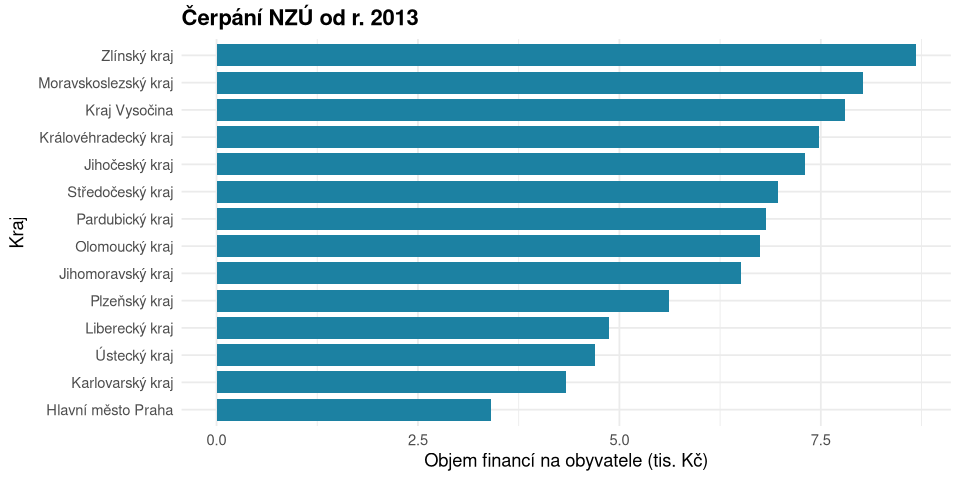

In [8]:
options(repr.plot.height = 4, repr.plot.width = 8)

aggregate_data(nzu, admin_level = "kraj", normalize = "pop") |>
  mutate(Region = fct_reorder(Region, AmountPerCapita)) |>
  ggplot(aes(AmountPerCapita / 1000, Region)) +
  geom_col(width = .8, fill = colours$teal) +
  labs(
    title = "Čerpání NZÚ od r. 2013",
    x = "Objem financí na obyvatele (tis. Kč)",
    y = "Kraj"
  )


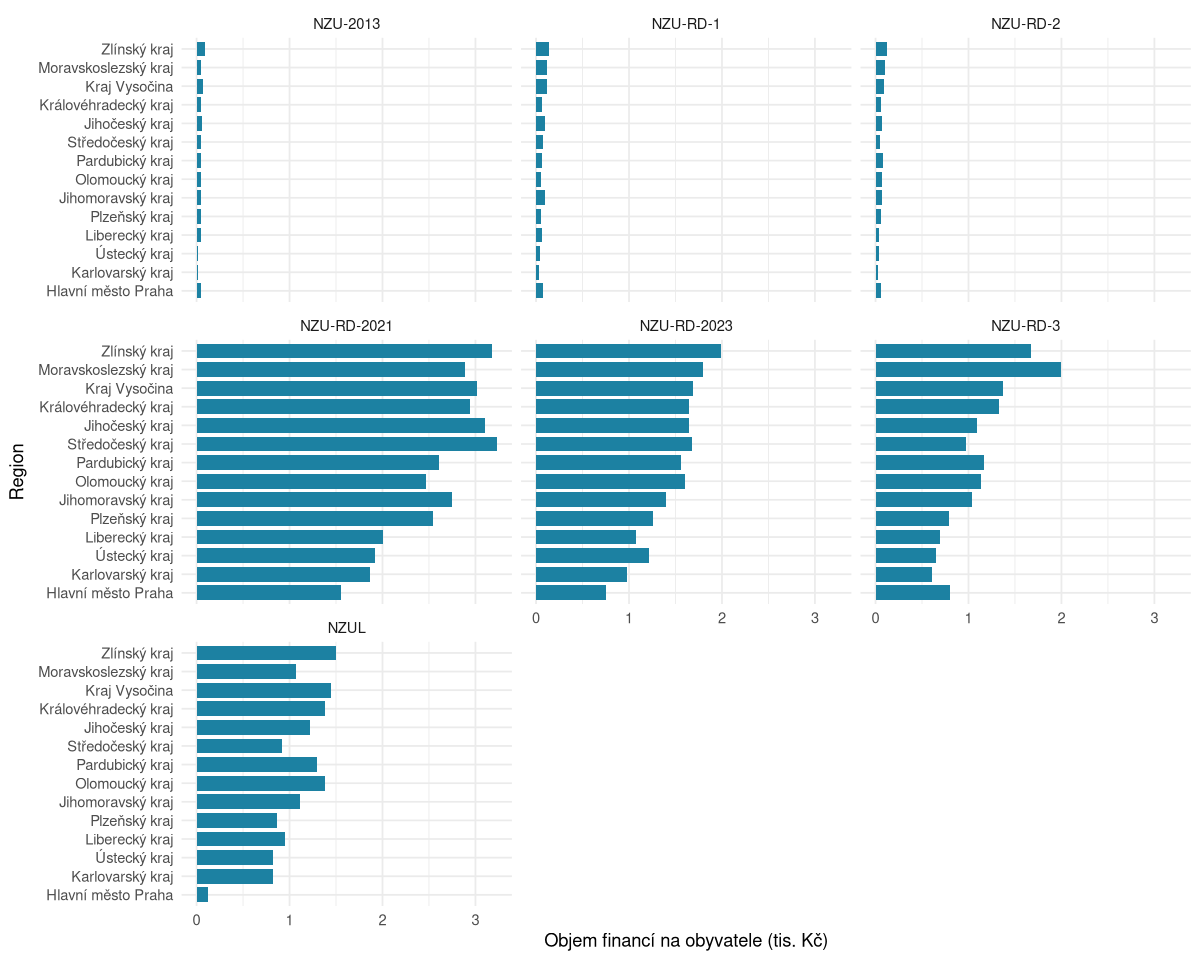

In [9]:
options(repr.plot.height = 8, repr.plot.width = 10)

aggregate_data(nzu, admin_level = "kraj", by = "call", normalize = "pop") |>
  mutate(Region = fct_reorder(Region, AmountPerCapita, sum)) |>
  ggplot(aes(AmountPerCapita / 1e3, Region)) +
  geom_col(width = .8, fill = colours$teal) +
  facet_wrap(vars(CallID)) +
  xlab("Objem financí na obyvatele (tis. Kč)")


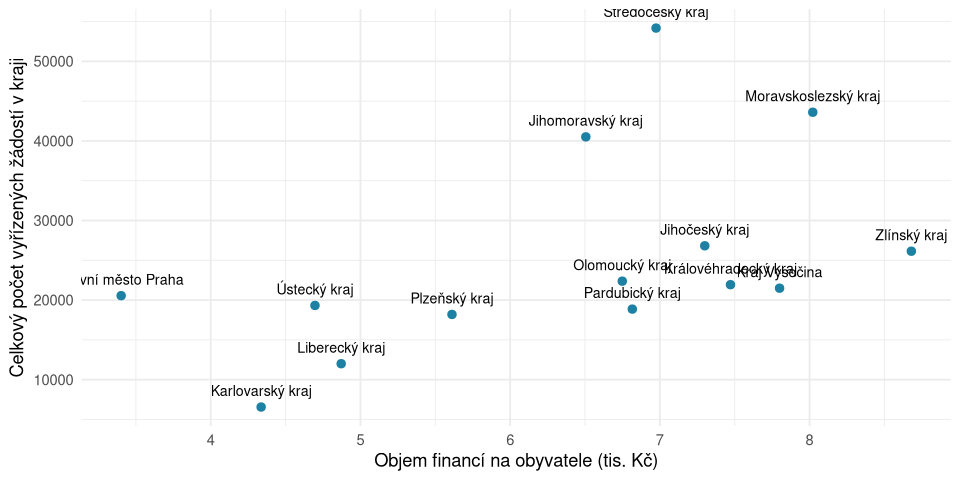

In [10]:
options(repr.plot.height = 4, repr.plot.width = 8)

aggregate_data(nzu, admin_level = "kraj", normalize = "pop") |>
  ggplot(aes(AmountPerCapita / 1e3, Count)) +
  geom_point(size = 2, colour = colours$teal) +
  geom_text(aes(label = Region), vjust = -1, size = 3) +
  labs(
    x = "Objem financí na obyvatele (tis. Kč)",
    y = "Celkový počet vyřízených žádostí v kraji"
  )


RCzechia: downloading remote dataset.

RCzechia: downloading remote dataset.



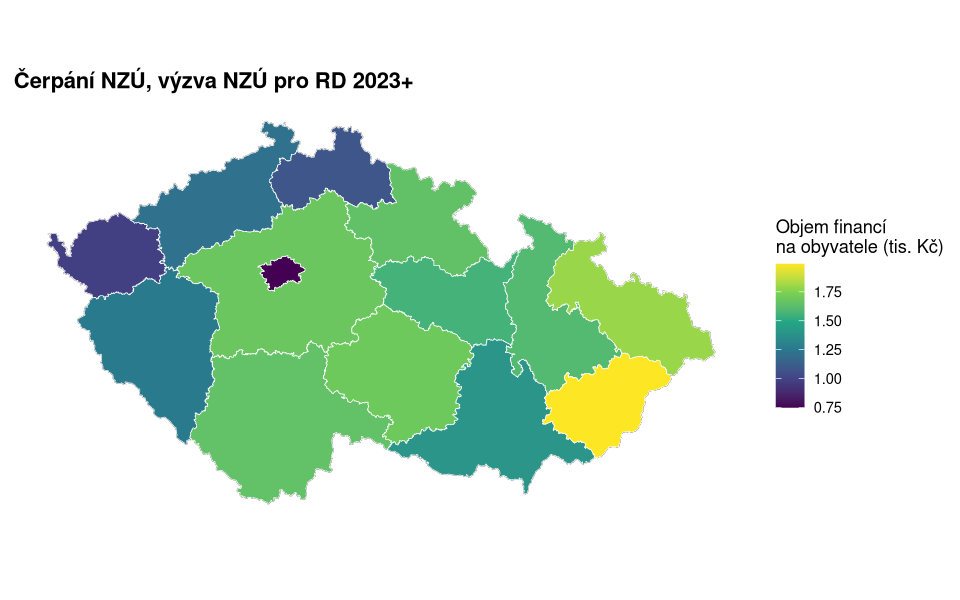

In [11]:
options(repr.plot.height = 5, repr.plot.width = 8)

kraje() |>
  left_join(
    aggregate_data(nzu, admin_level = "kraj", normalize = "pop", subset = CallID == "NZU-RD-2023"),
    join_by(NAZ_CZNUTS3 == Region)
  ) |>
  ggplot() +
  geom_sf(data = republika(), color = "black") +
  geom_sf(aes(fill = AmountPerCapita / 1e3), colour = "white") +
  scale_fill_viridis_c() +
  labs(
    title = "Čerpání NZÚ, výzva NZÚ pro RD 2023+",
    fill = "Objem financí\nna obyvatele (tis. Kč)"
  ) +
  theme_map()


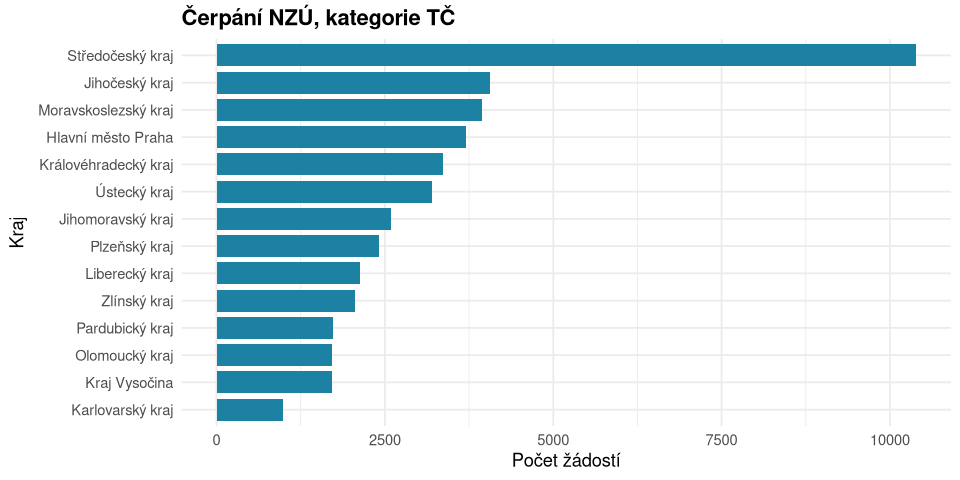

In [12]:
options(repr.plot.height = 4, repr.plot.width = 8)

category_select <- "TČ"

nzu |>
  aggregate_data(
    admin_level = "kraj",
    subset = str_detect(CategoriesDetail, category_select)
  ) |>
  mutate(Region = fct_reorder(Region, Count)) |>
  ggplot(aes(Count, Region)) +
  geom_col(width = .8, fill = colours$teal) +
  labs(
    title = str_glue("Čerpání NZÚ, kategorie {category_select}"),
    x = "Počet žádostí",
    y = "Kraj"
  )


RCzechia: using dataset stored locally in /tmp/RtmpYRP97m

RCzechia: using dataset stored locally in /tmp/RtmpYRP97m



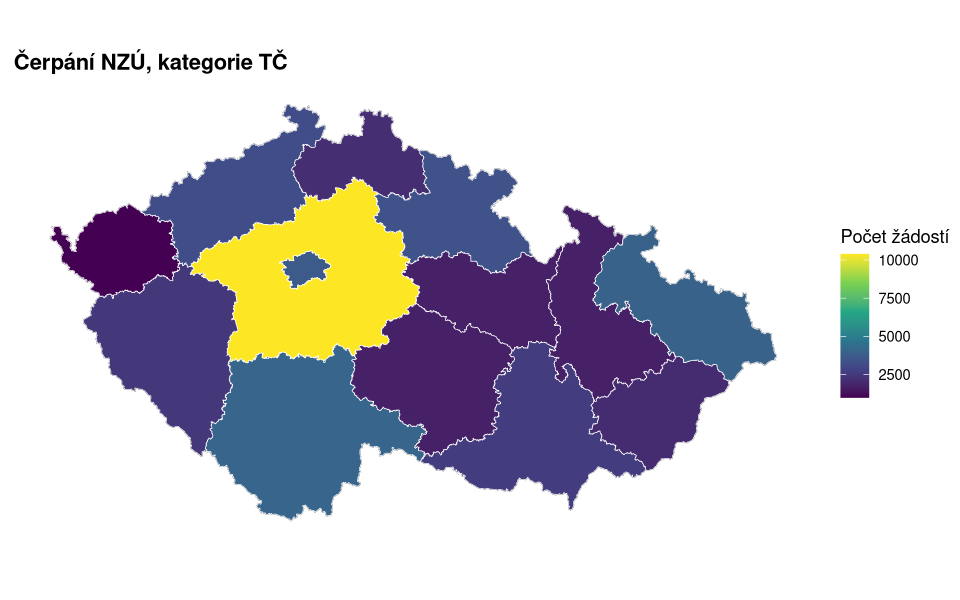

In [13]:
options(repr.plot.height = 5, repr.plot.width = 8)

category_select <- "TČ"

kraje() |>
  left_join(
    aggregate_data(nzu, admin_level = "kraj", subset = str_detect(CategoriesDetail, category_select)),
    join_by(NAZ_CZNUTS3 == Region)
  ) |>
  ggplot() +
  geom_sf(data = republika(), color = "black") +
  geom_sf(aes(fill = Count), colour = "white") +
  scale_fill_viridis_c() +
  labs(
    title = str_glue("Čerpání NZÚ, kategorie {category_select}"),
    fill = "Počet žádostí"
  ) +
  theme_map()


RCzechia: using dataset stored locally in /tmp/RtmpYRP97m

RCzechia: using dataset stored locally in /tmp/RtmpYRP97m



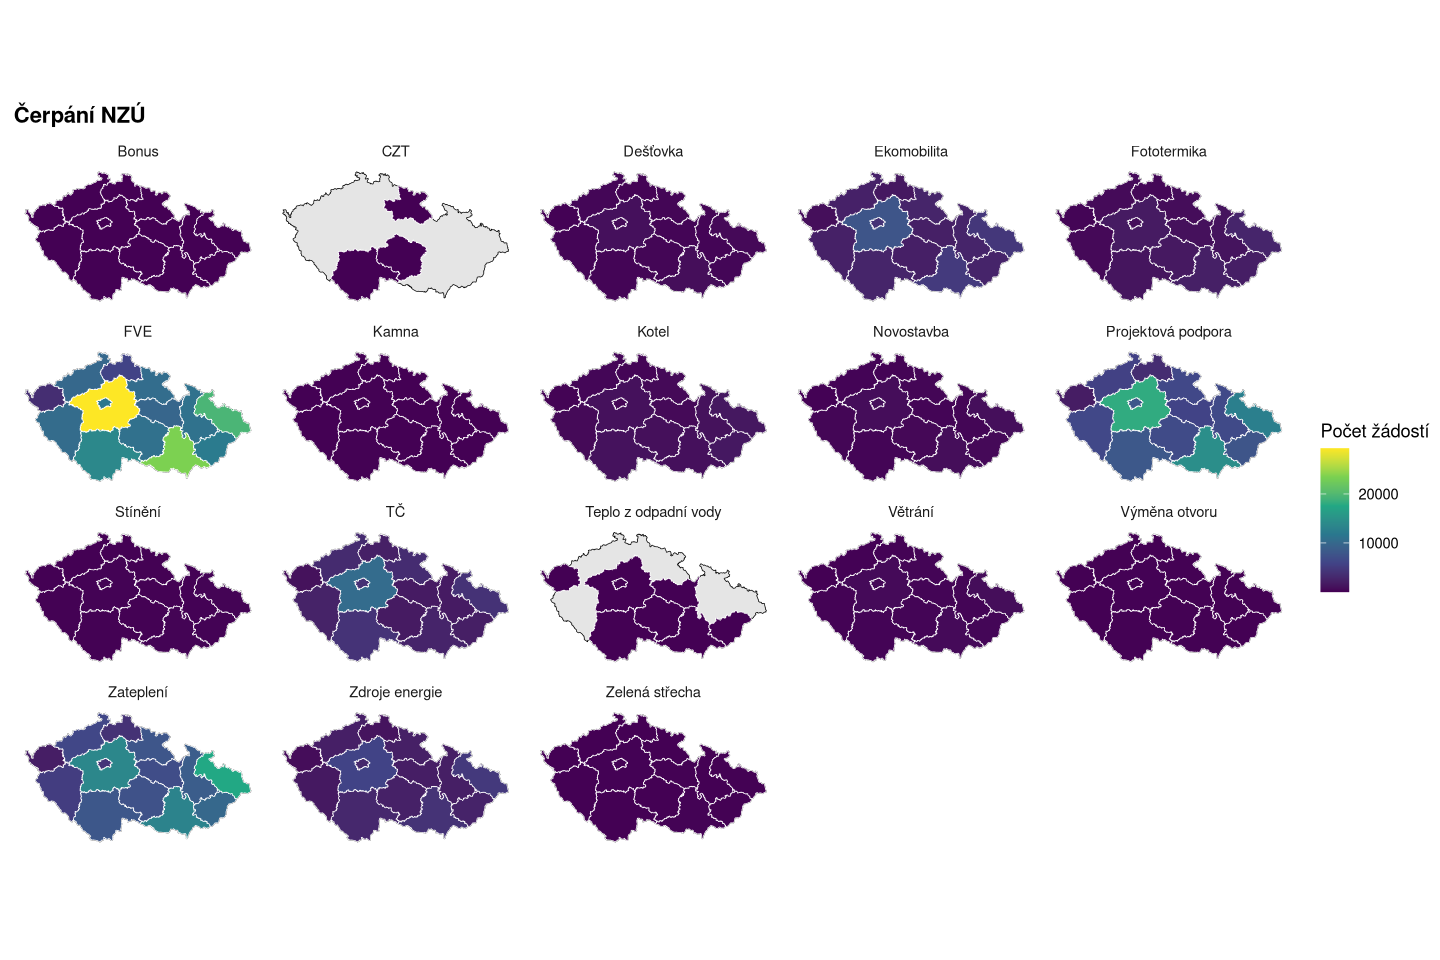

In [14]:
options(repr.plot.height = 8, repr.plot.width = 12)

kraje() |>
  left_join(
    aggregate_data(nzu, admin_level = "kraj", by = "categories") |>
      separate_longer_delim(CategoriesDetail, delim = "|") |>
      summarise(Count = sum(Count), .by = c(CategoriesDetail, Region)),
    join_by(NAZ_CZNUTS3 == Region)
  ) |>
  ggplot() +
  geom_sf(data = republika(), color = "black") +
  geom_sf(aes(fill = Count), colour = "white") +
  scale_fill_viridis_c() +
  facet_wrap(vars(CategoriesDetail)) +
  labs(
    title = "Čerpání NZÚ",
    fill = "Počet žádostí"
  ) +
  theme_map()


### Na úrovni ORP


RCzechia: downloading remote dataset.

RCzechia: using dataset stored locally in /tmp/RtmpYRP97m



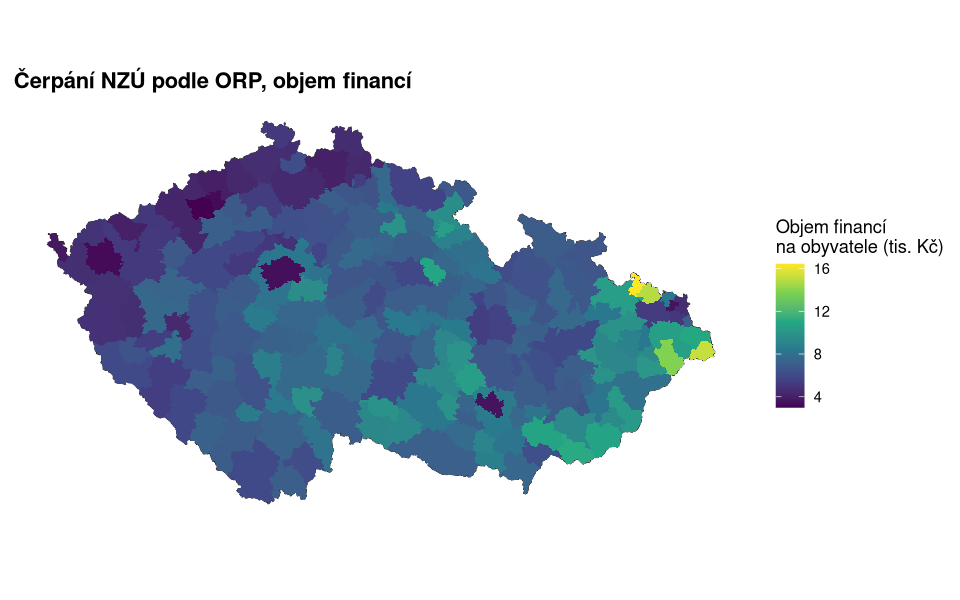

In [15]:
options(repr.plot.height = 5, repr.plot.width = 8)

orp_polygony() |>
  left_join(
    aggregate_data(nzu, admin_level = "orp", normalize = "pop"),
    join_by(KOD_ORP == ORPCode)
  ) |>
  ggplot() +
  geom_sf(data = republika(), color = "black") +
  geom_sf(aes(fill = AmountPerCapita / 1e3), colour = NA) +
  scale_fill_viridis_c() +
  labs(
    title = "Čerpání NZÚ podle ORP, objem financí",
    fill = "Objem financí\nna obyvatele (tis. Kč)"
  ) +
  theme_map()


RCzechia: using dataset stored locally in /tmp/RtmpYRP97m

RCzechia: using dataset stored locally in /tmp/RtmpYRP97m



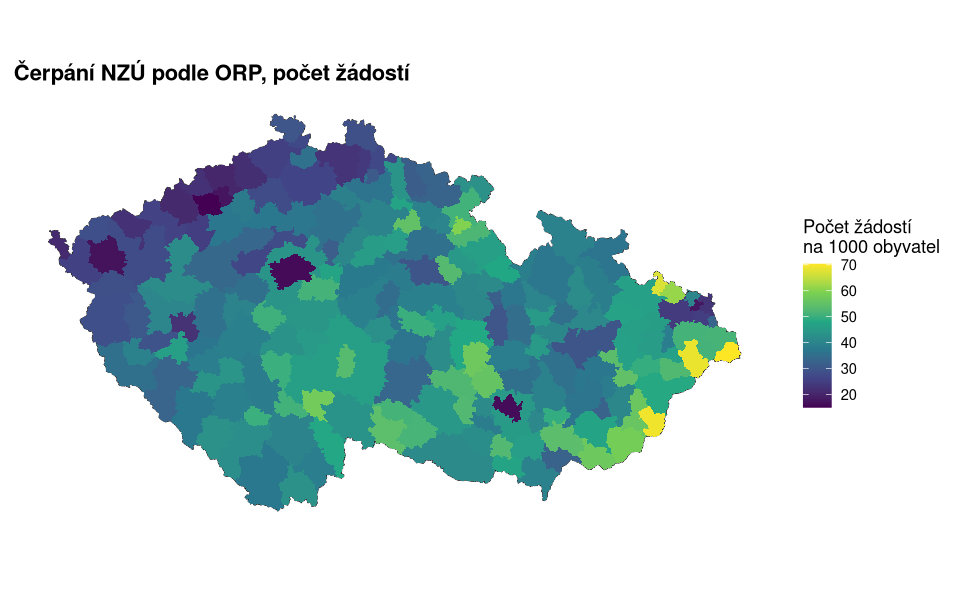

In [16]:
options(repr.plot.height = 5, repr.plot.width = 8)

orp_polygony() |>
  left_join(
    aggregate_data(nzu, admin_level = "orp", normalize = "pop"),
    join_by(KOD_ORP == ORPCode)
  ) |>
  ggplot() +
  geom_sf(data = republika(), color = "black") +
  geom_sf(aes(fill = CountPerCapita * 1000), colour = NA) +
  scale_fill_viridis_c() +
  labs(
    title = "Čerpání NZÚ podle ORP, počet žádostí",
    fill = "Počet žádostí\nna 1000 obyvatel"
  ) +
  theme_map()


RCzechia: using dataset stored locally in /tmp/RtmpYRP97m



RCzechia: using dataset stored locally in /tmp/RtmpYRP97m



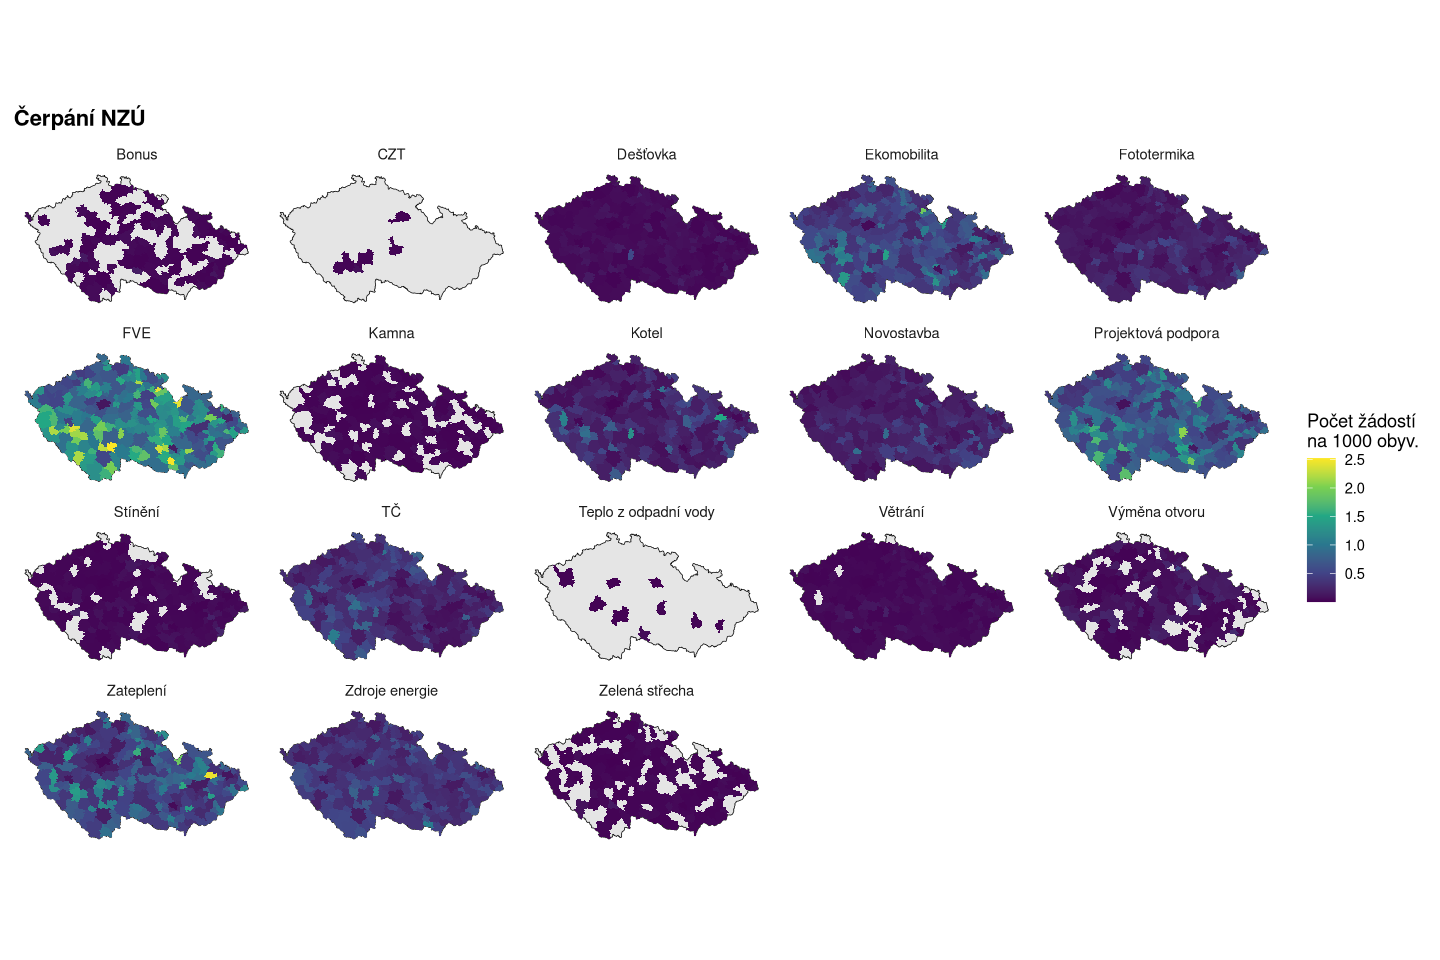

In [17]:
options(repr.plot.height = 8, repr.plot.width = 12)

orp_polygony() |>
  left_join(
    aggregate_data(nzu, admin_level = "orp", by = "categories", normalize = "pop") |>
      separate_longer_delim(CategoriesDetail, delim = "|") |>
      summarise(
        CountPerCapita = weighted.mean(CountPerCapita, Population),
        .by = c(CategoriesDetail, ORPCode)
      ),
    join_by(KOD_ORP == ORPCode)
  ) |>
  ggplot() +
  geom_sf(data = republika(), color = "black") +
  geom_sf(aes(fill = CountPerCapita * 1000), colour = NA) +
  scale_fill_viridis_c() +
  facet_wrap(vars(CategoriesDetail)) +
  labs(
    title = "Čerpání NZÚ",
    fill = "Počet žádostí\nna 1000 obyv."
  ) +
  theme_map()


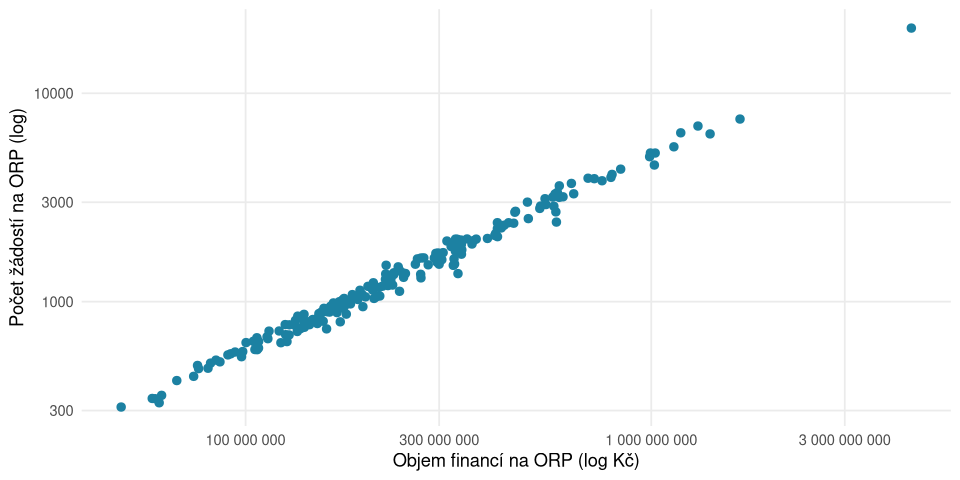

In [18]:
options(repr.plot.height = 4, repr.plot.width = 8)

aggregate_data(nzu, admin_level = "orp") |>
  ggplot(aes(AmountPaid, Count)) +
  geom_point(size = 2, colour = colours$teal) +
  scale_x_log10("Objem financí na ORP (log Kč)", labels = scales::label_number()) +
  scale_y_log10("Počet žádostí na ORP (log)") +
  theme(
    panel.grid.minor.x = element_blank(),
    panel.grid.minor.y = element_blank()
  )


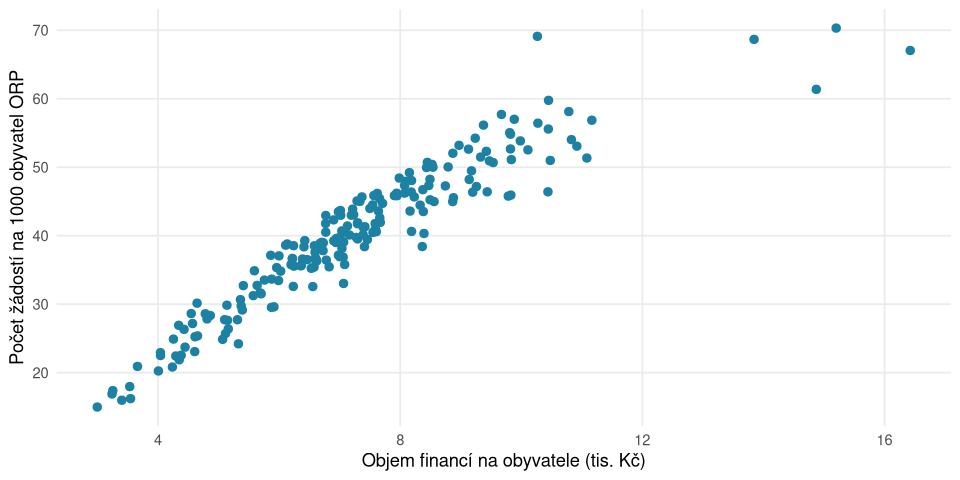

In [19]:
options(repr.plot.height = 4, repr.plot.width = 8)

aggregate_data(nzu, admin_level = "orp", normalize = "pop") |>
  ggplot(aes(AmountPerCapita / 1e3, CountPerCapita * 1e3)) +
  geom_point(size = 2, colour = colours$teal) +
  labs(
    x = "Objem financí na obyvatele (tis. Kč)",
    y = "Počet žádostí na 1000 obyvatel ORP"
  ) +
  theme(
    panel.grid.minor.x = element_blank(),
    panel.grid.minor.y = element_blank()
  )


### Na úrovni obcí


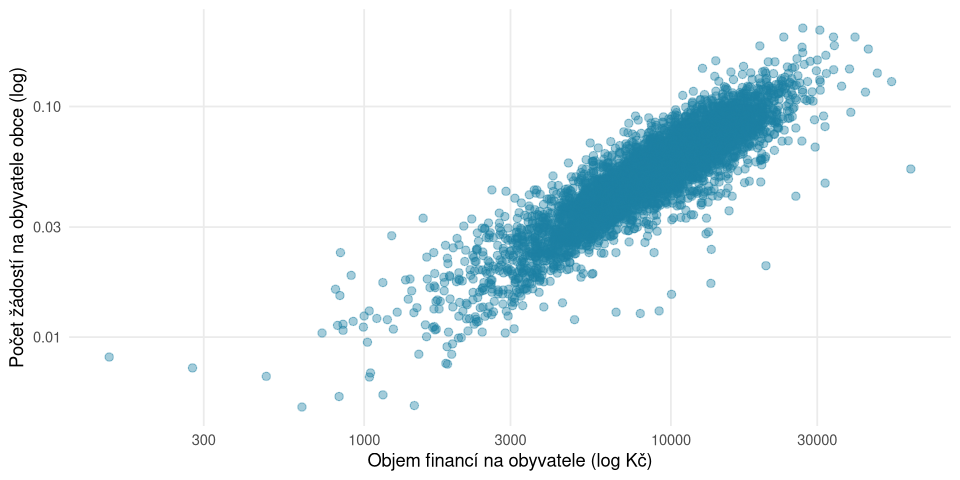

In [20]:
options(repr.plot.height = 4, repr.plot.width = 8)

aggregate_data(nzu, admin_level = "obec", normalize = "pop") |>
  ggplot(aes(AmountPerCapita, CountPerCapita)) +
  geom_point(size = 2, colour = colours$teal, alpha = .4) +
  scale_x_log10("Objem financí na obyvatele (log Kč)") +
  scale_y_log10("Počet žádostí na obyvatele obce (log)") +
  theme(
    panel.grid.minor.x = element_blank(),
    panel.grid.minor.y = element_blank()
  )


RCzechia: downloading remote dataset.

RCzechia: using dataset stored locally in /tmp/RtmpYRP97m



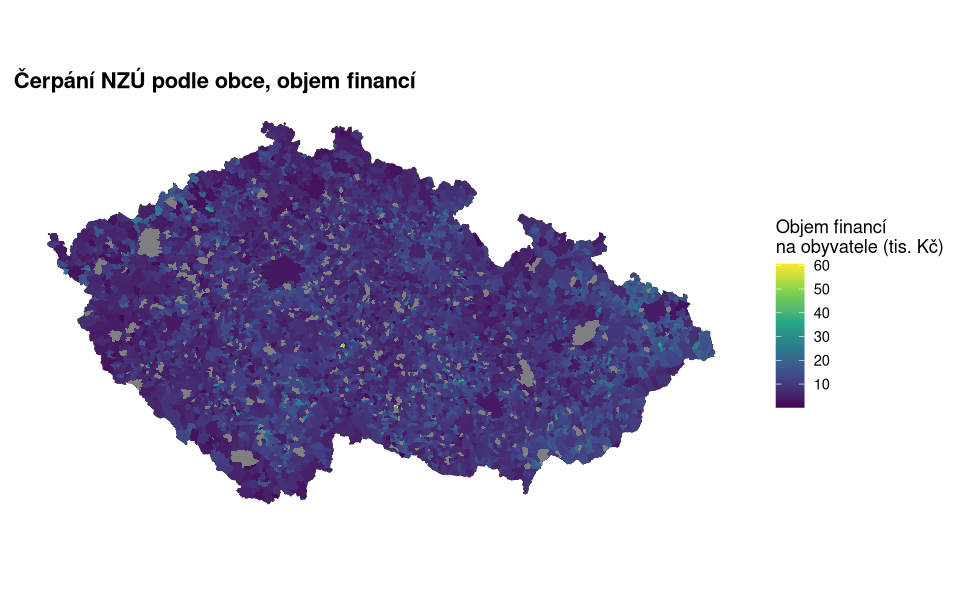

In [21]:
options(repr.plot.height = 5, repr.plot.width = 8)

obce_polygony() |>
  left_join(
    aggregate_data(nzu, admin_level = "obec", normalize = "pop"),
    join_by(KOD_OBEC == CityCode)
  ) |>
  ggplot() +
  geom_sf(data = republika(), color = "black") +
  geom_sf(aes(fill = AmountPerCapita / 1e3), colour = NA) +
  scale_fill_viridis_c() +
  labs(
    title = "Čerpání NZÚ podle obce, objem financí",
    fill = "Objem financí\nna obyvatele (tis. Kč)"
  ) +
  theme_map()


RCzechia: using dataset stored locally in /tmp/RtmpYRP97m



RCzechia: using dataset stored locally in /tmp/RtmpYRP97m



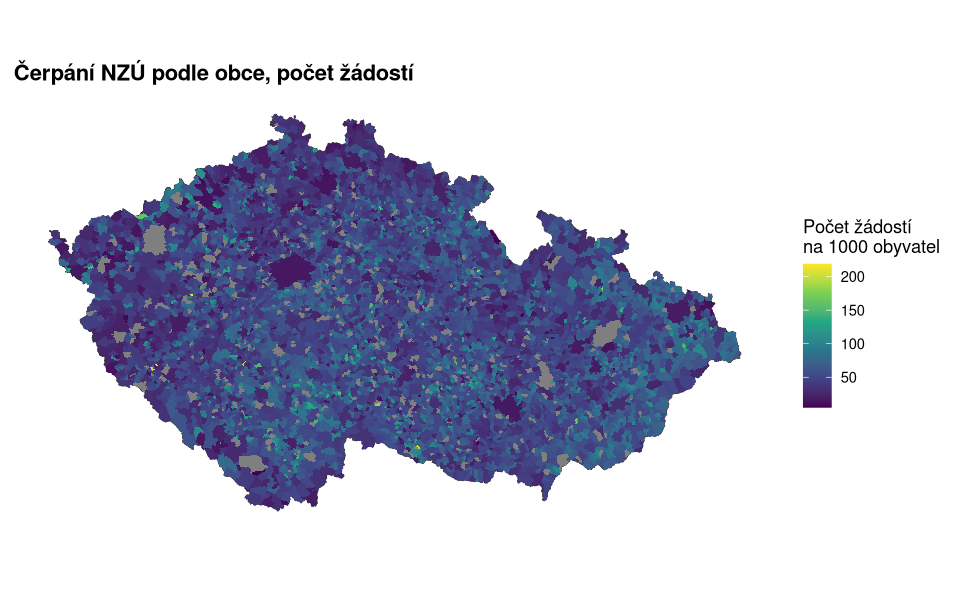

In [22]:
options(repr.plot.height = 5, repr.plot.width = 8)

obce_polygony() |>
  left_join(
    aggregate_data(nzu, admin_level = "obec", normalize = "pop"),
    join_by(KOD_OBEC == CityCode)
  ) |>
  ggplot() +
  geom_sf(data = republika(), color = "black") +
  geom_sf(aes(fill = CountPerCapita * 1e3), colour = NA) +
  scale_fill_viridis_c() +
  labs(
    title = "Čerpání NZÚ podle obce, počet žádostí",
    fill = "Počet žádostí\nna 1000 obyvatel"
  ) +
  theme_map()


## Přepočty na počet rodinných domů


### Na úrovni krajů


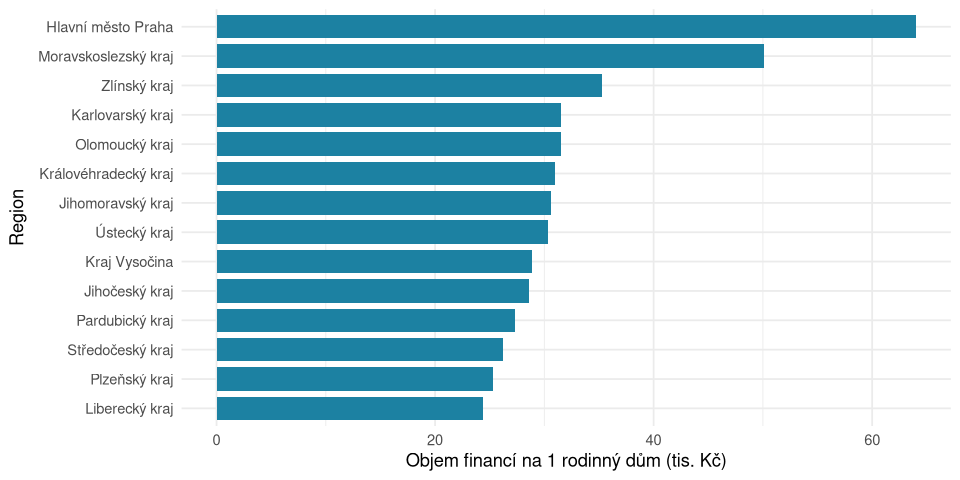

In [23]:
options(repr.plot.height = 4, repr.plot.width = 8)

aggregate_data(nzu, admin_level = "kraj", normalize = "houses") |>
  mutate(Region = fct_reorder(Region, AmountPerHouse, sum)) |>
  ggplot(aes(AmountPerHouse / 1e3, Region)) +
  geom_col(width = .8, fill = colours$teal) +
  xlab("Objem financí na 1 rodinný dům (tis. Kč)")


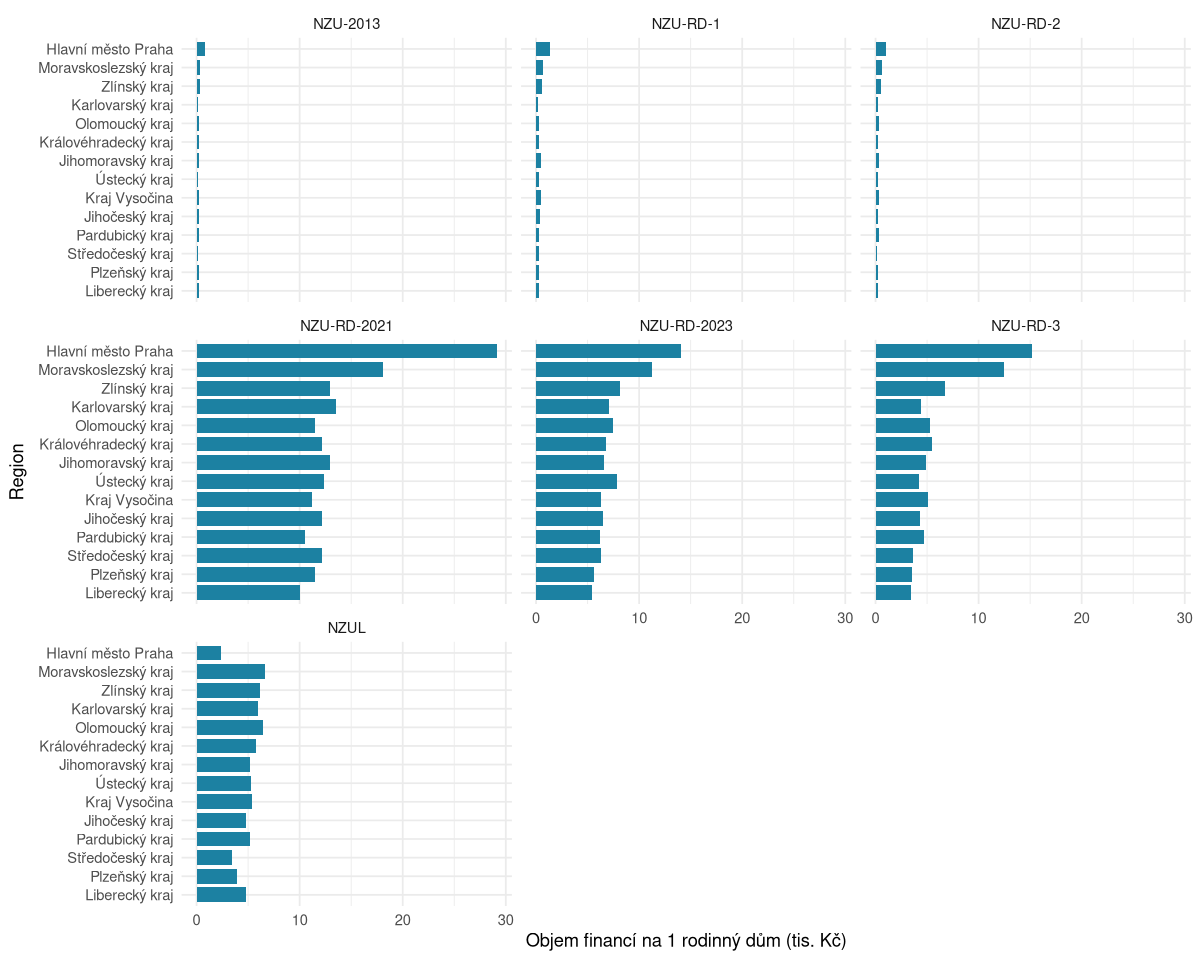

In [24]:
options(repr.plot.height = 8, repr.plot.width = 10)

aggregate_data(nzu, admin_level = "kraj", by = "call", normalize = "houses") |>
  mutate(Region = fct_reorder(Region, AmountPerHouse, sum)) |>
  ggplot(aes(AmountPerHouse / 1e3, Region)) +
  geom_col(width = .8, fill = colours$teal) +
  facet_wrap(vars(CallID)) +
  xlab("Objem financí na 1 rodinný dům (tis. Kč)")


### Na úrovni ORP


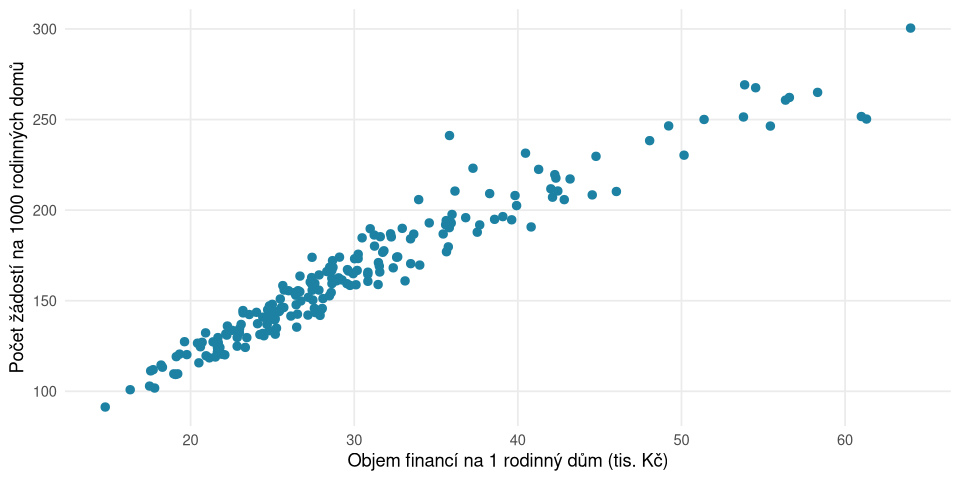

In [25]:
options(repr.plot.height = 4, repr.plot.width = 8)

aggregate_data(nzu, admin_level = "orp", normalize = "houses") |>
  ggplot(aes(AmountPerHouse / 1e3, CountPerHouse * 1000)) +
  geom_point(size = 2, colour = colours$teal) +
  labs(
    x = "Objem financí na 1 rodinný dům (tis. Kč)",
    y = "Počet žádostí na 1000 rodinných domů"
  ) +
  theme(
    panel.grid.minor.x = element_blank(),
    panel.grid.minor.y = element_blank()
  )


RCzechia: using dataset stored locally in /tmp/RtmpYRP97m

RCzechia: using dataset stored locally in /tmp/RtmpYRP97m



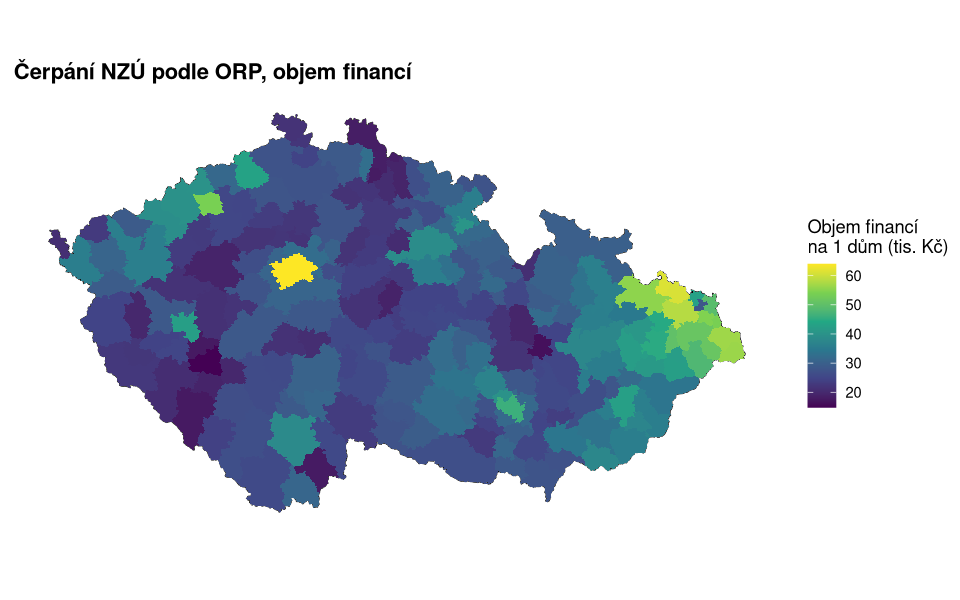

In [26]:
options(repr.plot.height = 5, repr.plot.width = 8)

orp_polygony() |>
  left_join(
    aggregate_data(nzu, admin_level = "orp", normalize = "houses"),
    join_by(KOD_ORP == ORPCode)
  ) |>
  ggplot() +
  geom_sf(data = republika(), color = "black") +
  geom_sf(aes(fill = AmountPerHouse / 1e3), colour = NA) +
  scale_fill_viridis_c() +
  labs(
    title = "Čerpání NZÚ podle ORP, objem financí",
    fill = "Objem financí\nna 1 dům (tis. Kč)"
  ) +
  theme_map()


RCzechia: using dataset stored locally in /tmp/RtmpYRP97m

RCzechia: using dataset stored locally in /tmp/RtmpYRP97m



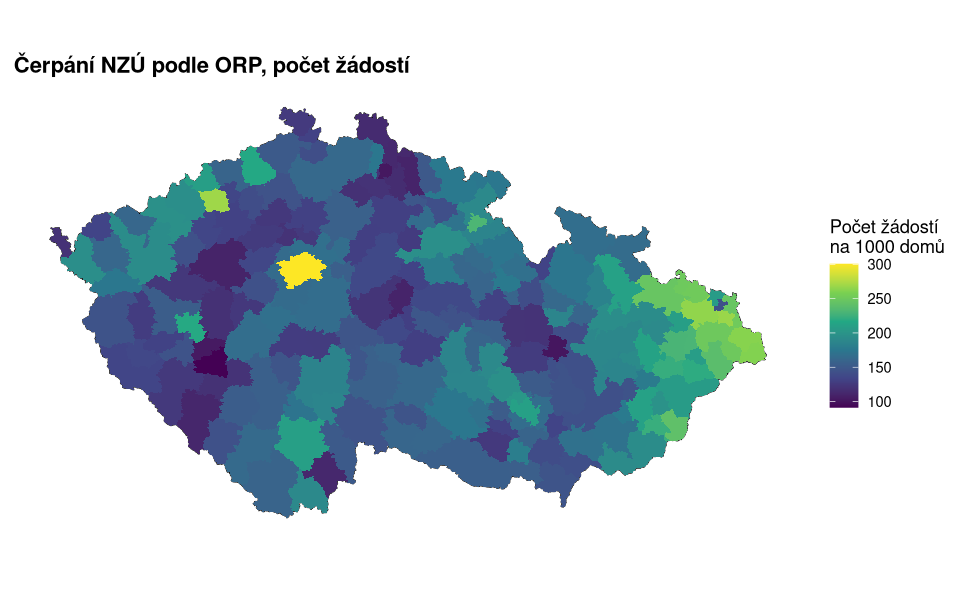

In [27]:
options(repr.plot.height = 5, repr.plot.width = 8)

orp_polygony() |>
  left_join(
    aggregate_data(nzu, admin_level = "orp", normalize = "houses"),
    join_by(KOD_ORP == ORPCode)
  ) |>
  ggplot() +
  geom_sf(data = republika(), color = "black") +
  geom_sf(aes(fill = CountPerHouse * 1e3), colour = NA) +
  scale_fill_viridis_c() +
  labs(
    title = "Čerpání NZÚ podle ORP, počet žádostí",
    fill = "Počet žádostí\nna 1000 domů"
  ) +
  theme_map()


RCzechia: using dataset stored locally in /tmp/RtmpYRP97m

RCzechia: using dataset stored locally in /tmp/RtmpYRP97m



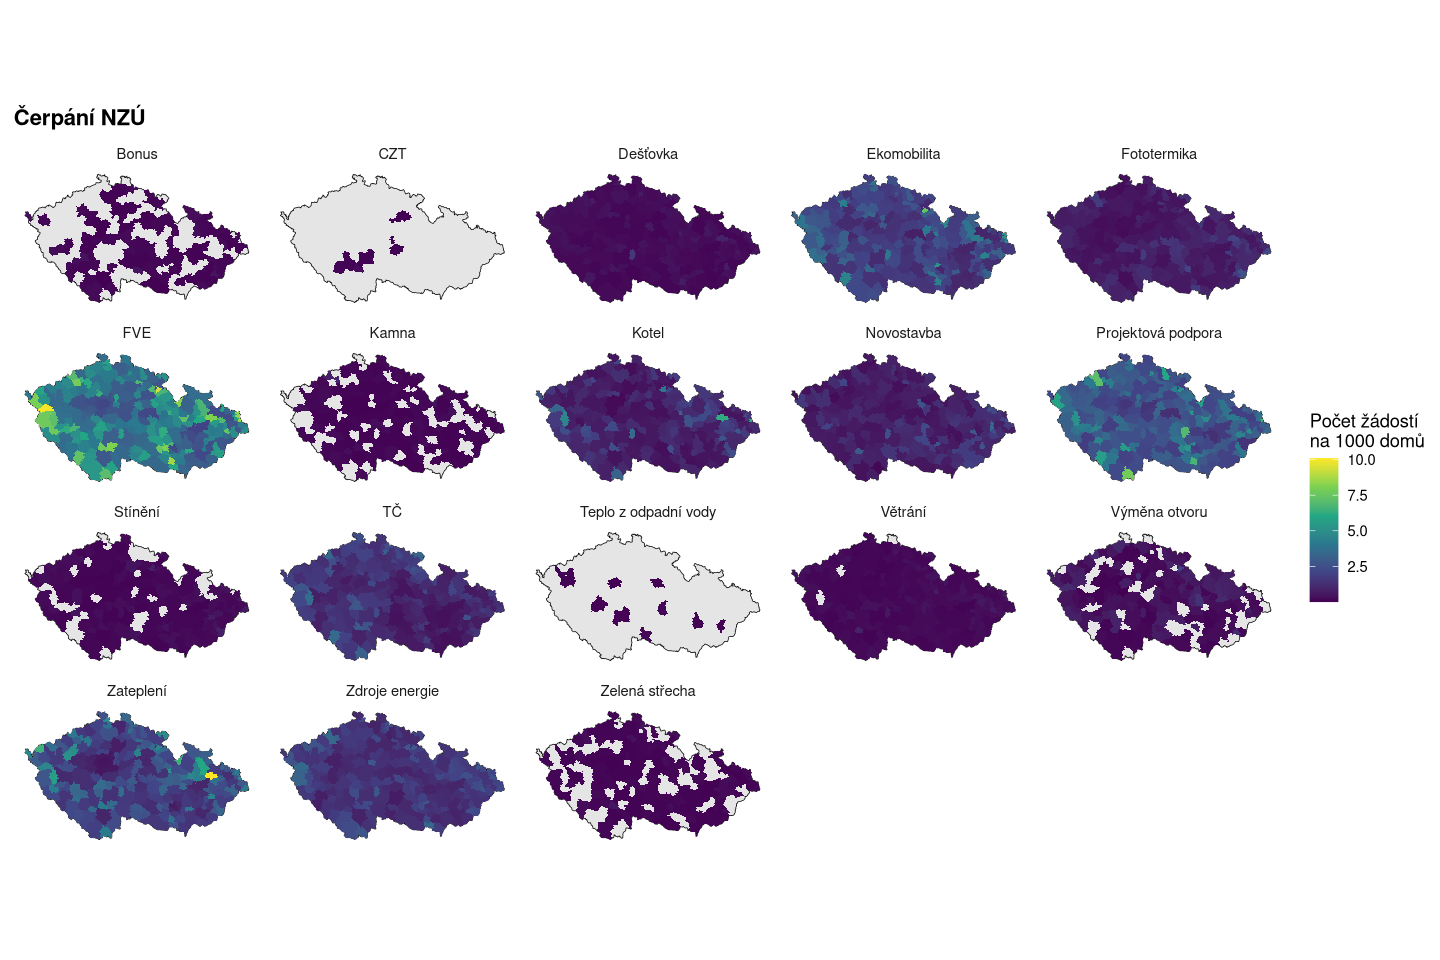

In [28]:
options(repr.plot.height = 8, repr.plot.width = 12)

orp_polygony() |>
  left_join(
    aggregate_data(nzu, admin_level = "orp", by = "categories", normalize = "houses") |>
      separate_longer_delim(CategoriesDetail, delim = "|") |>
      summarise(
        CountPerHouse = weighted.mean(CountPerHouse, NumHouses),
        .by = c(CategoriesDetail, ORPCode)
      ),
    join_by(KOD_ORP == ORPCode)
  ) |>
  ggplot() +
  geom_sf(data = republika(), color = "black") +
  geom_sf(aes(fill = CountPerHouse * 1000), colour = NA) +
  scale_fill_viridis_c() +
  facet_wrap(vars(CategoriesDetail)) +
  labs(
    title = "Čerpání NZÚ",
    fill = "Počet žádostí\nna 1000 domů"
  ) +
  theme_map()


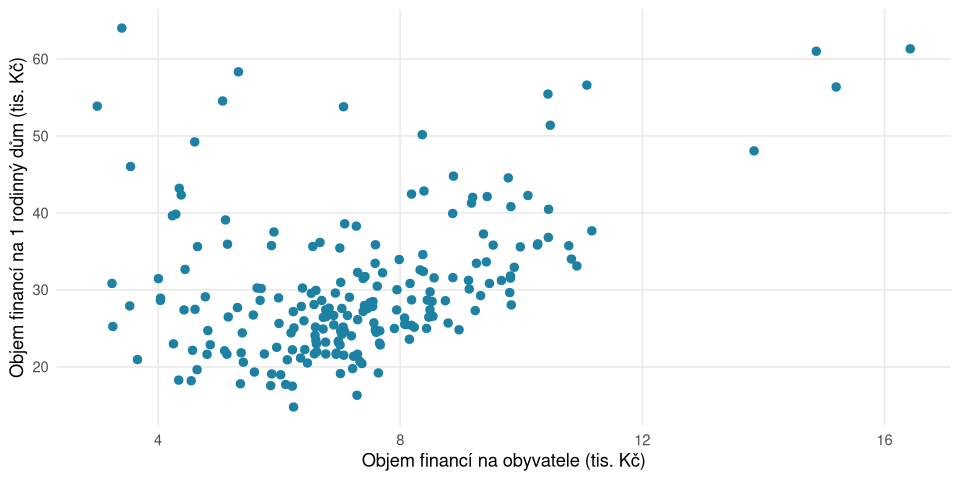

In [29]:
options(repr.plot.height = 4, repr.plot.width = 8)

inner_join(
  aggregate_data(nzu, admin_level = "orp", normalize = "pop") |>
    select(ORPCode, AmountPaid:CountPerCapita),
  aggregate_data(nzu, admin_level = "orp", normalize = "houses") |>
    select(ORPCode, NumHouses:CountPerHouse),
  join_by(ORPCode)
) |>
  ggplot(aes(AmountPerCapita / 1000, AmountPerHouse / 1000)) +
  geom_point(size = 2, colour = colours$teal) +
  labs(
    x = "Objem financí na obyvatele (tis. Kč)",
    y = "Objem financí na 1 rodinný dům (tis. Kč)"
  ) +
  theme(
    panel.grid.minor.x = element_blank(),
    panel.grid.minor.y = element_blank()
  )


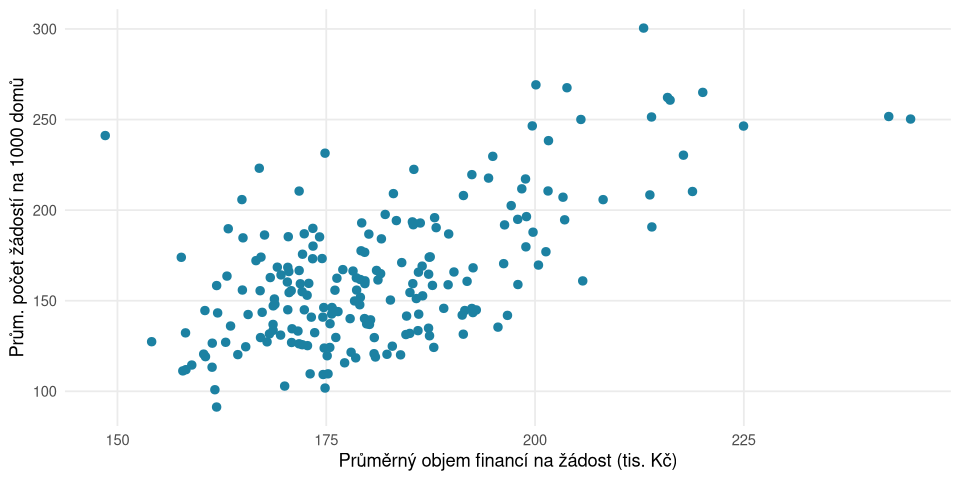

In [30]:
options(repr.plot.height = 4, repr.plot.width = 8)

inner_join(
  aggregate_data(nzu, admin_level = "orp", normalize = "pop") |>
    select(ORPCode, AmountPaid:CountPerCapita),
  aggregate_data(nzu, admin_level = "orp", normalize = "houses") |>
    select(ORPCode, NumHouses:CountPerHouse),
  join_by(ORPCode)
) |>
  ggplot(aes(AmountPaid / Count / 1000, CountPerHouse * 1000)) +
  geom_point(size = 2, colour = colours$teal) +
  labs(
    x = "Průměrný objem financí na žádost (tis. Kč)",
    y = "Prům. počet žádostí na 1000 domů"
  ) +
  theme(
    panel.grid.minor.x = element_blank(),
    panel.grid.minor.y = element_blank()
  )


## Přepočty na HDP


### Na úrovni krajů

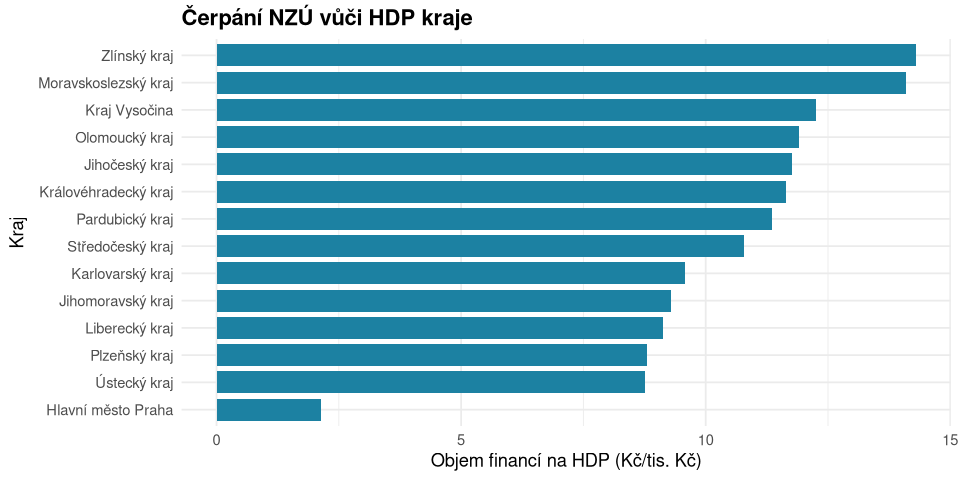

In [31]:
options(repr.plot.height = 4, repr.plot.width = 8)

aggregate_data(nzu, admin_level = "kraj", normalize = "gdp") |>
  mutate(Region = fct_reorder(Region, AmountPerGDP)) |>
  # NOTE: GDP in CZSO dataset is in mil. CZK. Recalculate to CZK per 1000 CZK
  ggplot(aes(AmountPerGDP / 1000, Region)) +
  geom_col(width = .8, fill = colours$teal) +
  labs(
    title = "Čerpání NZÚ vůči HDP kraje",
    x = "Objem financí na HDP (Kč/tis. Kč)",
    y = "Kraj"
  )


RCzechia: using dataset stored locally in /tmp/RtmpYRP97m

RCzechia: using dataset stored locally in /tmp/RtmpYRP97m



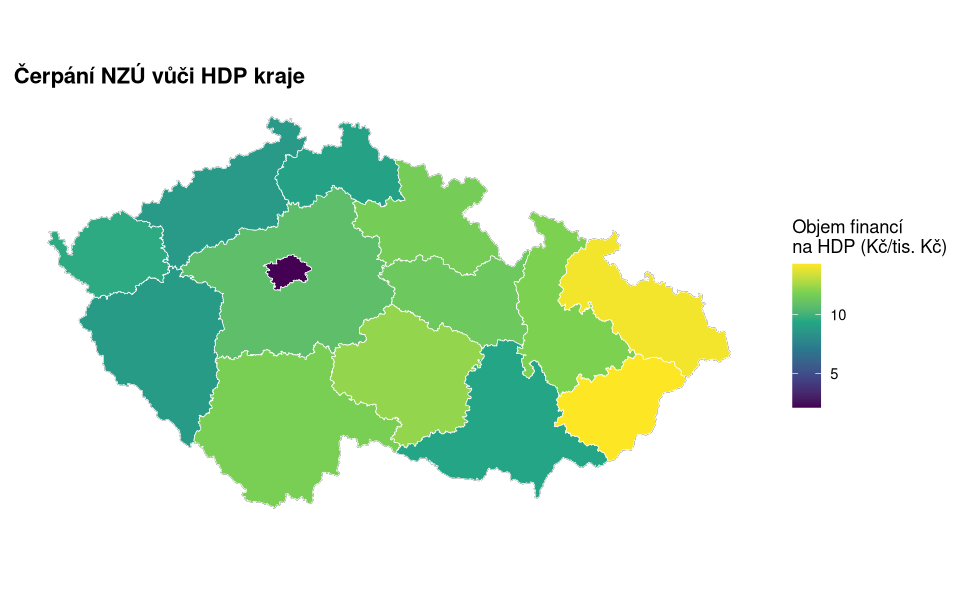

In [32]:
options(repr.plot.height = 5, repr.plot.width = 8)

kraje() |>
  left_join(
    aggregate_data(nzu, admin_level = "kraj", normalize = "gdp"),
    join_by(NAZ_CZNUTS3 == Region)
  ) |>
  ggplot() +
  geom_sf(data = republika(), color = "black") +
  # NOTE: GDP in CZSO dataset is in mil. CZK. Recalculate to CZK per 1000 CZK
  geom_sf(aes(fill = AmountPerGDP / 1000), colour = "white") +
  scale_fill_viridis_c() +
  labs(
    title = "Čerpání NZÚ vůči HDP kraje",
    fill = "Objem financí\nna HDP (Kč/tis. Kč)"
  ) +
  theme_map()


## Kombinace podpor


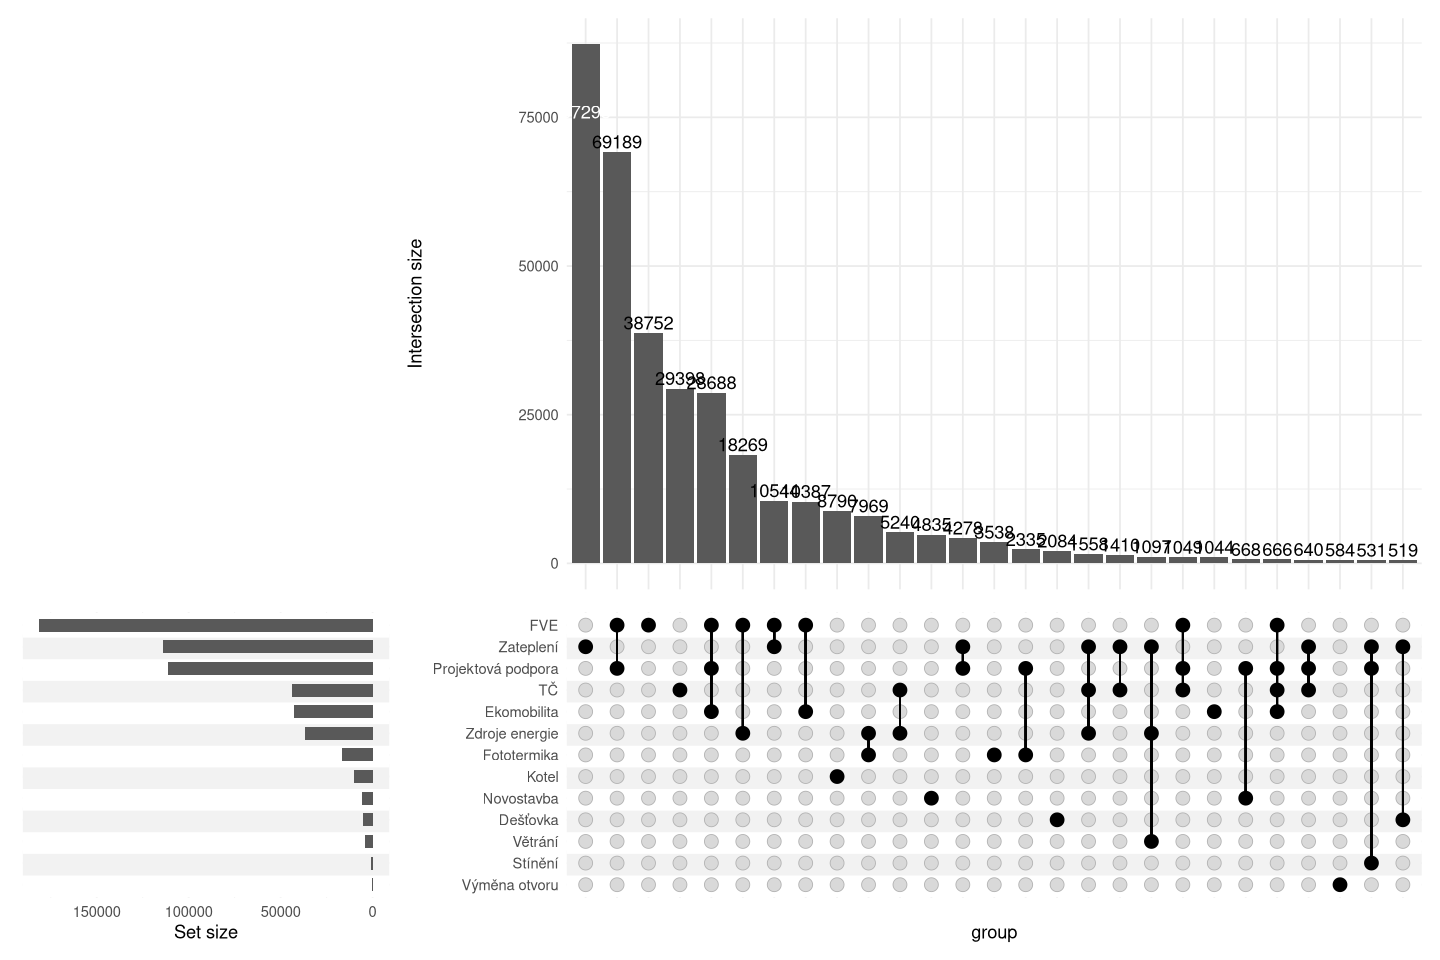

In [ ]:
options(repr.plot.height = 8, repr.plot.width = 12)

nzu_categories_wide <- nzu |>
  select(CallID, ApplicationID, CategoriesDetail) |>
  separate_longer_delim(CategoriesDetail, delim = "|") |>
  mutate(Flag = 1) |>
  pivot_wider(names_from = CategoriesDetail, values_from = Flag, values_fill = 0)

activity_colnames <- select(nzu_categories_wide, !1:2) |> colnames()

# Show groupings with 500 applications or more.
ComplexUpset::upset(nzu_categories_wide, activity_colnames, min_size = 500)
